In [1]:
import nengo
import numpy as np
import matplotlib.pyplot as plt

In [72]:
def run_conditioning_network(η = 0.5e-4, T = 10.0):

    with nengo.Network() as model:
        nd_stim_us = nengo.Node(lambda t:
            (1.0 if 0.6 < (t % 1.0) < 1.0 else 0.0) *
            (1.0 if t < 5.0 else 0.0) *
            (1.0 if t > 1.0 else 0.0)
        )
        nd_stim_cs = nengo.Node(lambda t:
            (1.0 if 0.6 < (t % 1.0) < 1.0 else 0.0)
        )

        # Inputs
        ens_us = nengo.Ensemble(n_neurons=100, dimensions=1)
        ens_cs = nengo.Ensemble(n_neurons=100, dimensions=1)
        nengo.Connection(nd_stim_us, ens_us)
        nengo.Connection(nd_stim_cs, ens_cs)

        # Unconditioned response
        ens_ur = nengo.Ensemble(n_neurons=100, dimensions=1)
        nengo.Connection(ens_us, ens_ur)

        # Conditioned response
        ens_cr = nengo.Ensemble(n_neurons=100, dimensions=1)
        con = nengo.Connection(
            ens_cs,
            ens_cr,
            learning_rule_type=nengo.PES(η),
            transform=np.zeros((1, 1)))

        # Learning
        ens_err = nengo.Ensemble(n_neurons=100, dimensions=1)
        nengo.Connection(ens_cr, ens_err, transform=1)
        nengo.Connection(ens_ur, ens_err, transform=-1)
        nengo.Connection(ens_err, con.learning_rule)

        # Total response
        ens_response = nengo.Ensemble(n_neurons=100, dimensions=1)
        nengo.Connection(ens_cr, ens_response)
        nengo.Connection(ens_ur, ens_response)

        # Recorders
        p_us = nengo.Probe(ens_us, synapse=20e-3)
        p_cs = nengo.Probe(ens_cs, synapse=20e-3)
        p_ur = nengo.Probe(ens_ur, synapse=20e-3)
        p_cr = nengo.Probe(ens_cr, synapse=20e-3)
        p_res = nengo.Probe(ens_response, synapse=20e-3)

    with nengo.Simulator(model) as sim:
        sim.run(T)
        ts = sim.trange()

    return ts, sim.data[p_us], sim.data[p_cs], sim.data[p_ur], sim.data[p_cr], sim.data[p_res]

In [73]:
data = run_conditioning_network()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [86]:
def plot_conditioning_network(ts, uss, css, urs, crs, res):
    fig, axs = plt.subplots(3, 1, figsize=(6.5, 3), sharex=True)

    axs[0].plot(ts, uss, color='k')
    axs[0].set_ylim(-0.1, 1.25)
    axs[0].set_ylabel('Response\nMagnitude')
    axs[0].set_title('Unconditioned Stimulus (US)')

    axs[1].plot(ts, css, color='k')
    axs[1].set_ylim(-0.1, 1.25)
    axs[1].set_ylabel('Response\nMagnitude')
    axs[1].set_title('Conditioned Stimulus (CS)')

    axs[2].plot(ts, urs, linewidth=1, label='UR')
    axs[2].plot(ts, crs, linewidth=1, label='CR')
    axs[2].plot(ts, res, color='k')
    axs[2].set_ylim(-0.1, 1.25)
    axs[2].set_title('Response (UR + CR)')
    axs[2].set_ylabel('Response\nMagnitude')
    axs[2].set_xlabel('Time $t$ (s)')
    axs[2].legend()

    fig.tight_layout()

    return fig, axs

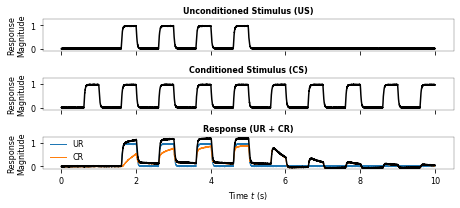

In [87]:
fig, axs = plot_conditioning_network(*data)
fig.savefig('../classical_conditioning_experiment.pdf', bbox_inches='tight', transparent=True)